<a href="https://colab.research.google.com/github/retroam/Calcium-analysis/blob/master/calcium_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
pip install ipympl scikit-image -q

In [58]:
from google.colab import output
output.enable_custom_widget_manager()

In [52]:
%matplotlib widget

In [53]:
import os
import numpy as np 
from PIL import Image
from PIL.TiffTags import TAGS
import cv2

In [12]:
image_path = "/content/experiment.tif"

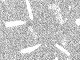

(60, 80)


In [43]:
with Image.open(image_path) as img:
  img.show()
  info = {TAGS[key] : img.tag[key] for key in img.tag.keys()}
  I = np.asarray(img)
  print(I.shape)

In [42]:
info

{'ImageWidth': (80,),
 'ImageLength': (60,),
 'BitsPerSample': (16,),
 'Compression': (1,),
 'PhotometricInterpretation': (1,),
 'ImageDescription': ('<MetaData>\r\n\t<prop id="Description" type="string" value="Acquired from Hamamatsu DCAM Camera&amp;#13;&amp;#10;Exposure: 15 msec&amp;#13;&amp;#10;Binning: 8 X 8&amp;#13;&amp;#10;Region: 640 x 480, offset at (0, 0)&amp;#13;&amp;#10;Digitizer: High-precision (12-bit)&amp;#13;&amp;#10;Gain: 15&amp;#13;&amp;#10;Bit Depth: 12&amp;#13;&amp;#10;Cooler On: 1&amp;#13;&amp;#10;Frames to Average: 1&amp;#13;&amp;#10;">\r\n\t</prop>\r\n\t<prop id="MetaDataVersion" type="float" value="1">\r\n\t</prop>\r\n\t<prop id="ApplicationName" type="string" value="MetaMorph">\r\n\t</prop>\r\n\t<prop id="ApplicationVersion" type="string" value="7.5.6.0">\r\n\t</prop>\r\n\t<PlaneInfo>\r\n\t\t<prop id="plane-type" type="string" value="plane">\r\n\t\t</prop>\r\n\t\t<prop id="pixel-size-x" type="int" value="80">\r\n\t\t</prop>\r\n\t\t<prop id="pixel-size-y" type="i

In [67]:
import imageio.v3 as iio
from skimage import filters, measure, segmentation, feature, io
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

In [55]:
image = iio.imread(uri=image_path)

In [59]:
print(image.shape)

(7337, 60, 80)


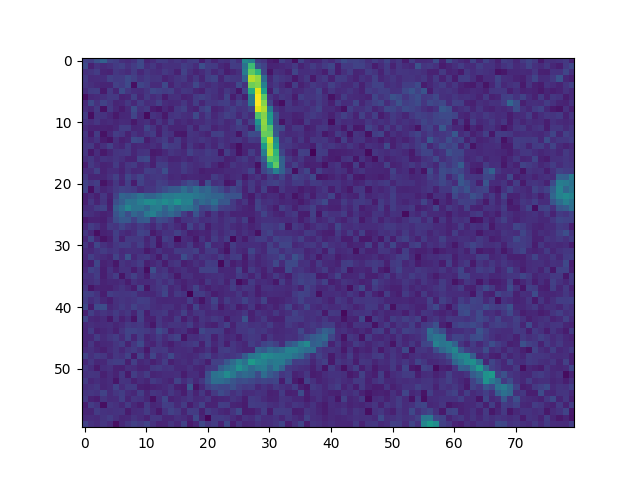

In [61]:
fig, ax = plt.subplots(1, 1)
ax.imshow(image[1,:,:])

In [82]:
I_mean = np.mean(image, axis=0)
# Perform thresholding
I_bw1 = I_mean > filters.threshold_local(I_mean, block_size=15)
# Perform morphological opening
I_bw2 = ndi.binary_opening(I_bw1, structure=np.ones((3, 3)))
# Identify connected components
labels = measure.label(I_bw2)

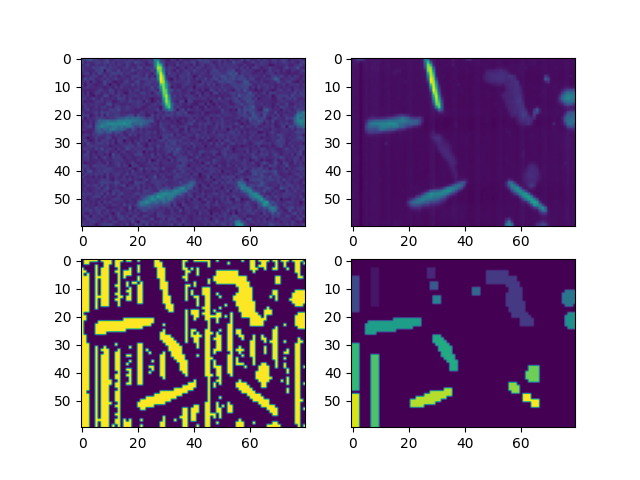

In [83]:
fig, ax = plt.subplots(2, 2)
ax[0][0].imshow(image[1,:,:])
ax[0][1].imshow(I_mean)
ax[1][0].imshow(I_bw1)
ax[1][1].imshow(labels)

In [89]:
data = []
bkg = []
for I in np.rollaxis(image, axis=0):
    # Get properties of labeled regions
    props = measure.regionprops(labels, intensity_image=I)
    
    # Compute the mean intensity of each region and the background
    avg = [prop.mean_intensity for prop in props]
    I_bkg = I.copy().astype(float)
    for prop in props:
        I_bkg[prop.coords[:, 0], prop.coords[:, 1]] = np.nan
    bkg_intensity = np.nanmean(I_bkg)

    data.append(avg)
    bkg.append(bkg_intensity)

In [97]:
import pandas as pd

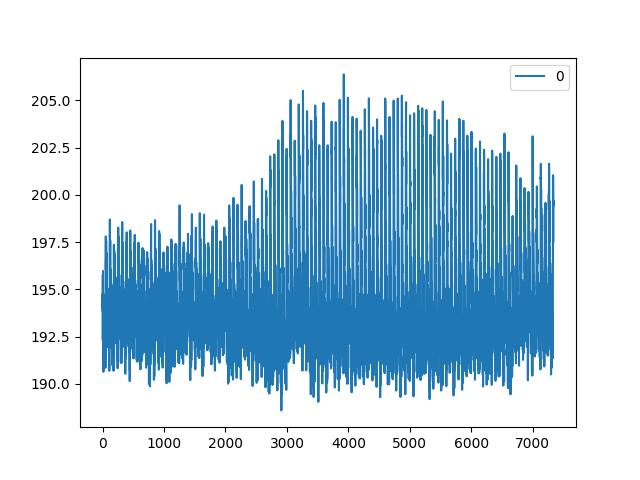

In [100]:
pd.DataFrame(bkg).plot();

In [101]:
df = pd.DataFrame(data)

In [102]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,196.309524,524.166667,224.029197,192.871795,538.444444,181.888889,189.925926,500.333333,321.045455,315.086420,213.679245,193.039216,190.025641,217.444444,313.285714,326.421053,190.000000,343.944444
1,197.571429,535.666667,224.043796,189.128205,530.222222,176.222222,200.740741,510.333333,328.590909,314.703704,212.339623,195.549020,196.615385,213.370370,307.714286,334.228070,193.888889,353.555556
2,197.595238,521.250000,228.036496,202.666667,528.333333,186.000000,189.740741,466.444444,334.409091,313.543210,213.905660,192.313725,191.884615,219.444444,317.142857,322.929825,193.250000,340.611111
3,197.547619,508.833333,226.715328,194.025641,517.000000,196.111111,193.259259,475.333333,328.863636,308.308642,215.490566,192.980392,191.051282,228.111111,312.785714,323.947368,194.888889,351.388889
4,192.166667,493.666667,227.014599,198.871795,516.666667,186.222222,185.851852,474.333333,325.545455,305.679012,206.981132,191.960784,191.641026,219.888889,302.714286,320.771930,200.277778,349.444444


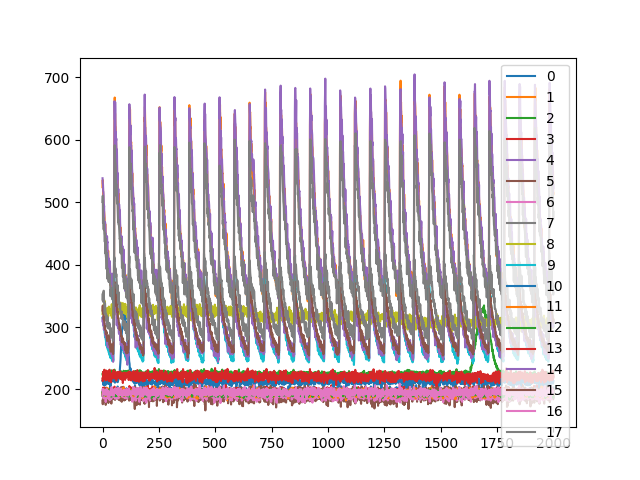

In [107]:
df.loc[0:2000].plot();